In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE

# Preparation

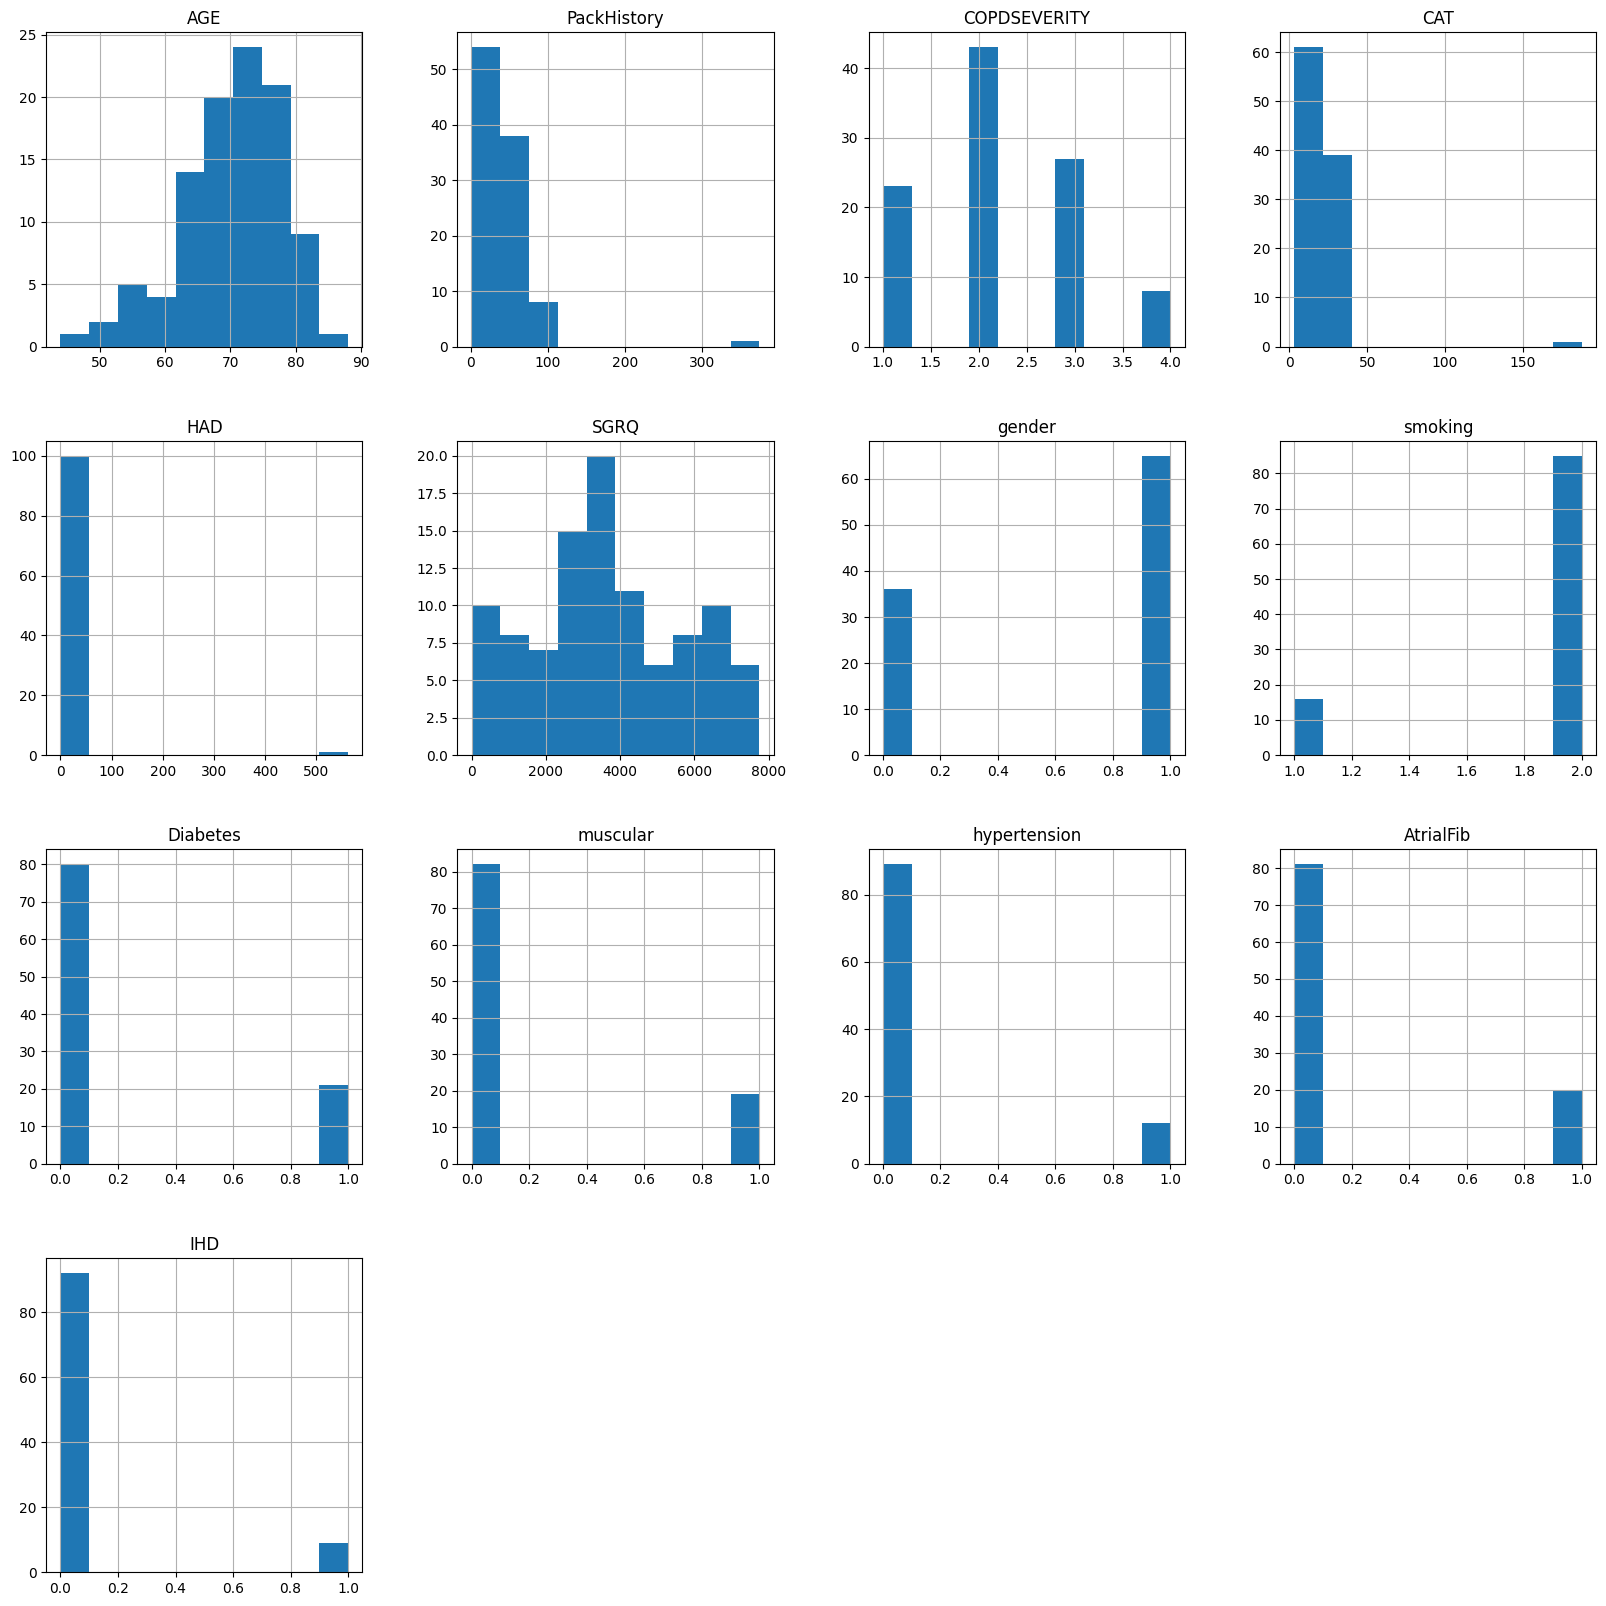

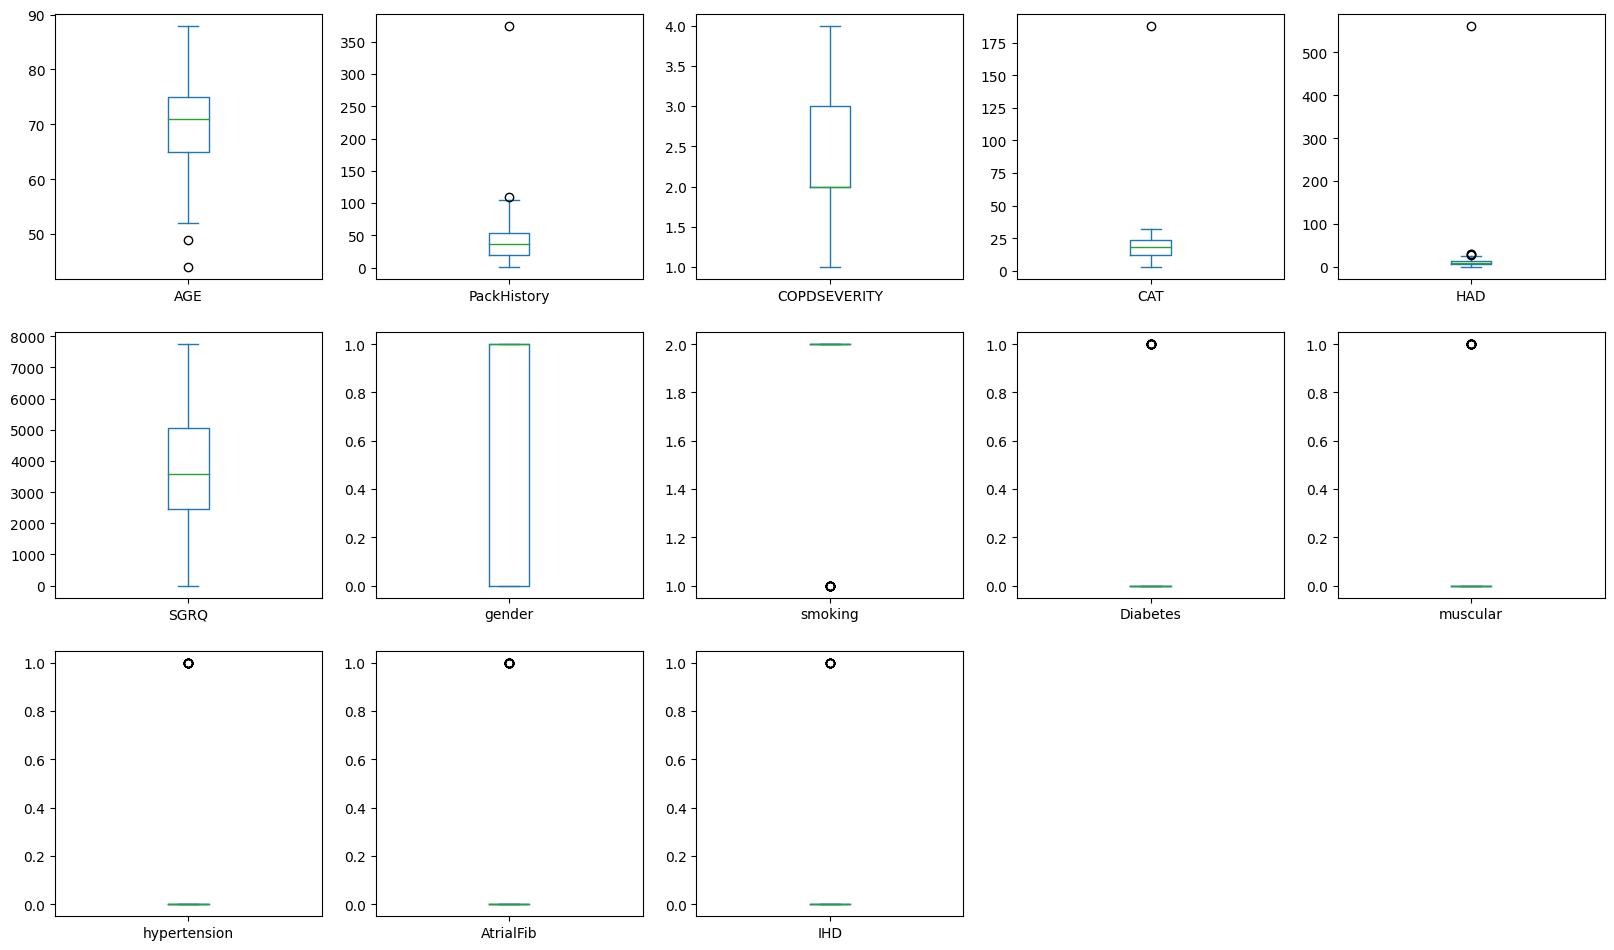

In [51]:


from matplotlib.pyplot import savefig, show, subplots

kaggle = pd.read_csv('data/dataset.csv', sep=';')

# drop the second row
kaggle = kaggle.drop(kaggle.index[0])
# drop ID column
kaggle = kaggle.drop(columns=['ID'])
# drop FEV1pred cause it seems useless
kaggle = kaggle.drop(columns=['FEV1PRED'])
# drop FVCpred cause it seems useless
kaggle = kaggle.drop(columns=['FVCPRED'])
# drop AGEquartiles cause it seems useless
kaggle = kaggle.drop(columns=['AGEquartiles'])
# drop MWT1 and MWT2
kaggle = kaggle.drop(columns=['MWT1'])
kaggle = kaggle.drop(columns=['MWT2'])
# drop copd so we only have one target
kaggle = kaggle.drop(columns=['copd'])

# try dropping all spirometry values
kaggle = kaggle.drop(columns=["FEV1", "FVC"])

# turn COPDSEVERITY in categories: MILD = 1, MODERATE = 2, SEVERE = 3, VERY SEVERE = 4
kaggle['COPDSEVERITY'] = kaggle['COPDSEVERITY'].replace(['MILD'], 1)
kaggle['COPDSEVERITY'] = kaggle['COPDSEVERITY'].replace(['MODERATE'], 2)
kaggle['COPDSEVERITY'] = kaggle['COPDSEVERITY'].replace(['SEVERE'], 3)
kaggle['COPDSEVERITY'] = kaggle['COPDSEVERITY'].replace(['VERY SEVERE'], 4)

# plot histograms for each variable using the number of variables in the dataset
kaggle.hist(figsize=(20,20), sharex=False, sharey=False)
# show boxplot for each variable
kaggle.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(20,20))
plt.show()


array([[<AxesSubplot: title={'center': 'AGE'}>,
        <AxesSubplot: title={'center': 'PackHistory'}>,
        <AxesSubplot: title={'center': 'MWT1Best'}>,
        <AxesSubplot: title={'center': 'CAT'}>],
       [<AxesSubplot: title={'center': 'HAD'}>,
        <AxesSubplot: title={'center': 'SGRQ'}>,
        <AxesSubplot: title={'center': 'gender'}>,
        <AxesSubplot: title={'center': 'smoking'}>],
       [<AxesSubplot: title={'center': 'Diabetes'}>,
        <AxesSubplot: title={'center': 'muscular'}>,
        <AxesSubplot: title={'center': 'hypertension'}>,
        <AxesSubplot: title={'center': 'AtrialFib'}>],
       [<AxesSubplot: title={'center': 'IHD'}>,
        <AxesSubplot: title={'center': 'COPDSEVERITY'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

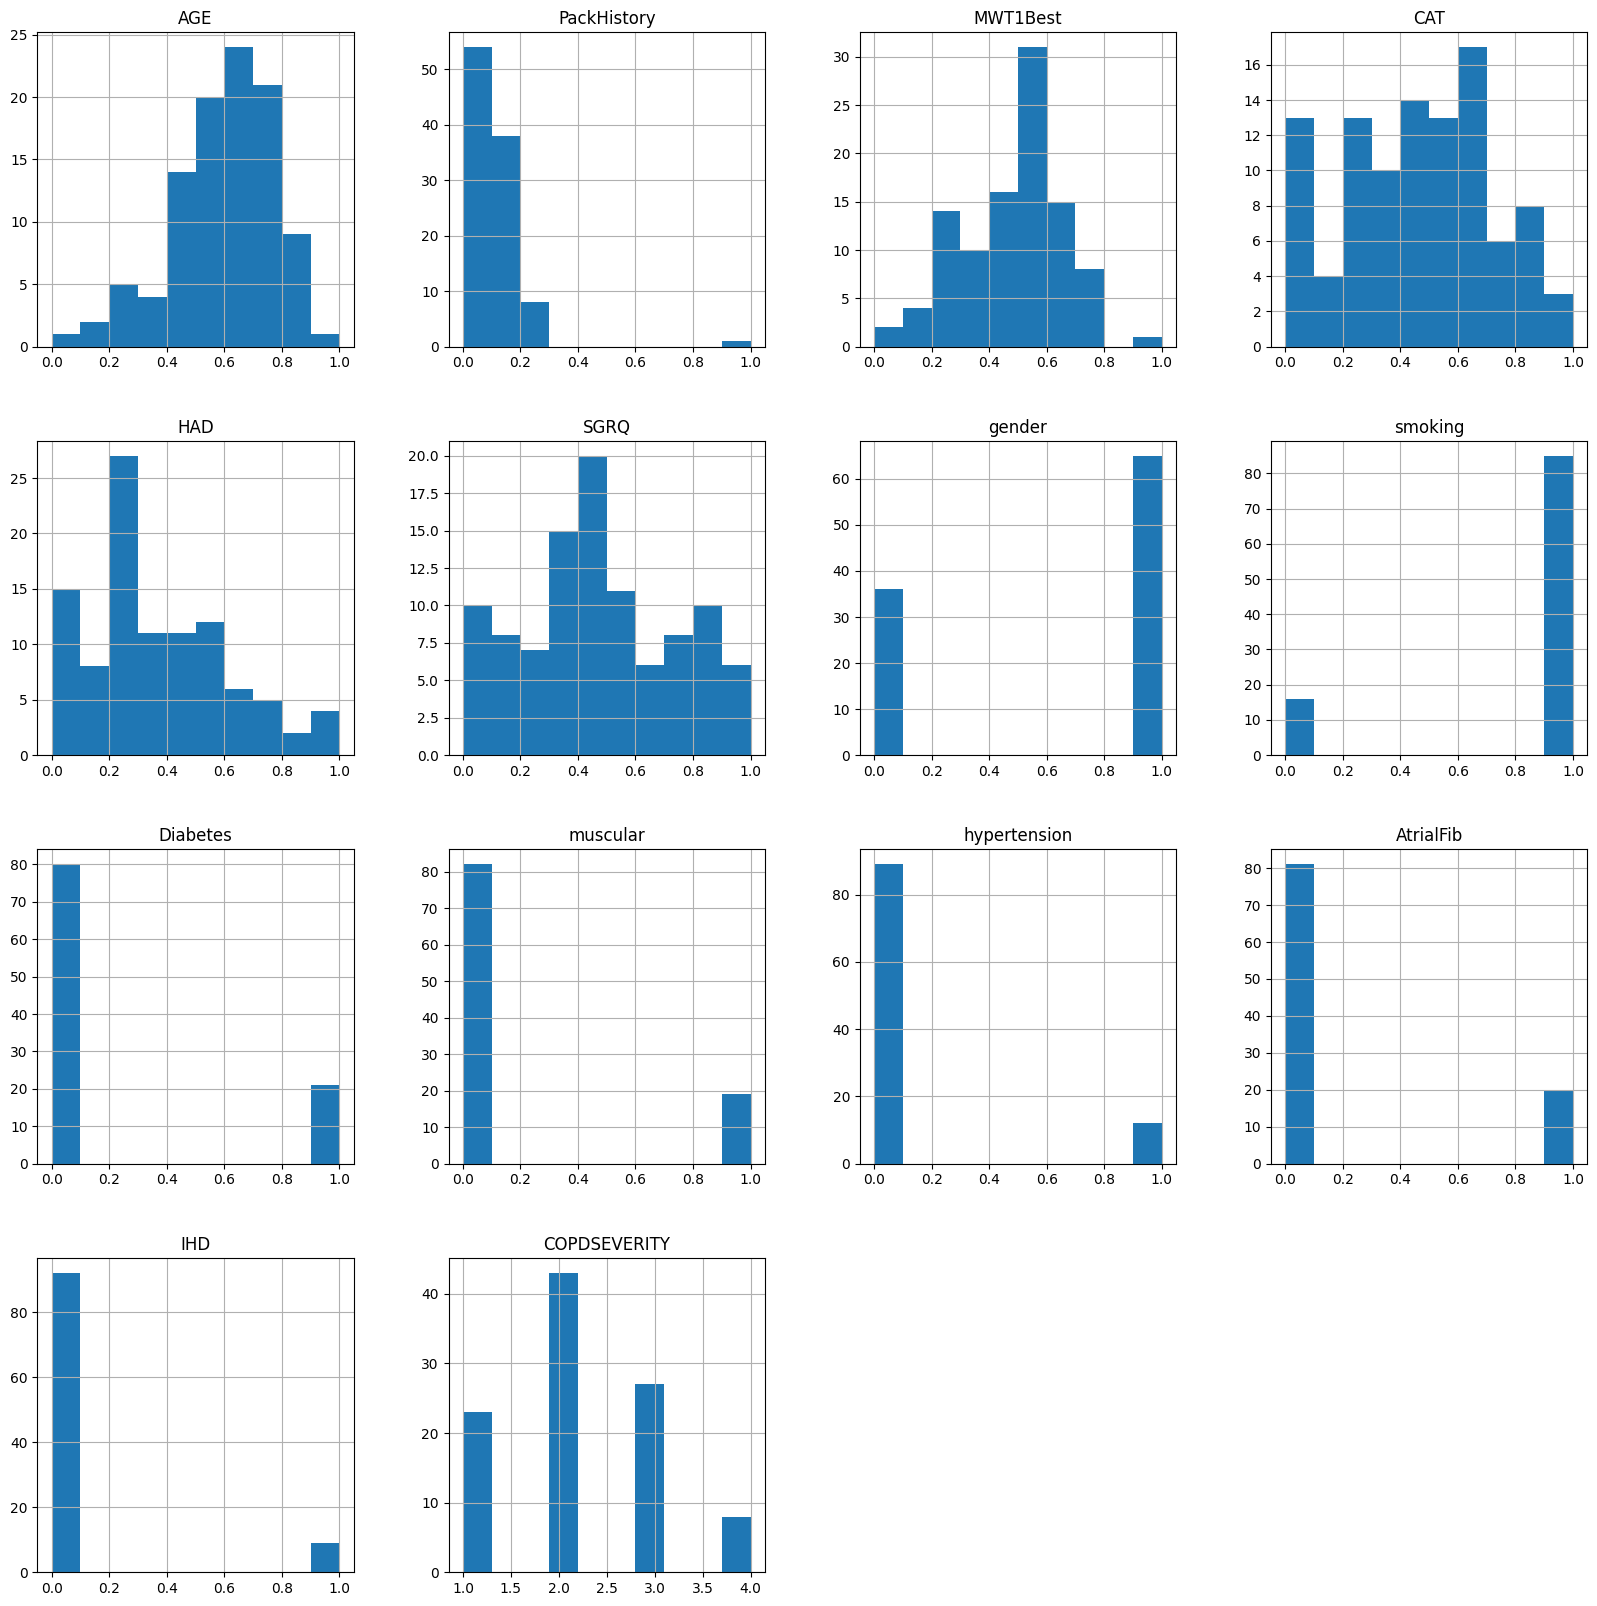

In [52]:
########
# Missing Values
########

# replace all the missing values in MWT1Best with the median
kaggle['MWT1Best'] = kaggle['MWT1Best'].fillna(kaggle['MWT1Best'].median())

#########
# Outliers
#########

# CAT can be 35 at most so we set all the values above 35 to 35
kaggle.loc[kaggle['CAT'] > 35, 'CAT'] = 35
# HAD can be 30 at most so we set all the values above 30 to 30
kaggle.loc[kaggle['HAD'] > 30, 'HAD'] = 30

#########
# Scaling
#########

# use minmax scaling to scale everything except the target
target = kaggle['COPDSEVERITY']
kaggle = kaggle.drop(columns=['COPDSEVERITY'])

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(kaggle)
tmp = DataFrame(transf.transform(kaggle), index=kaggle.index, columns=kaggle.columns)
kaggle= concat([tmp, target], axis=1)

# plot histograms for each variable using the number of variables in the dataset
kaggle.hist(figsize=(20,20), sharex=False, sharey=False)



In [53]:
# balance the dataset
X = kaggle.drop(columns=['COPDSEVERITY'])
y = kaggle['COPDSEVERITY']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
kaggle = concat([X, y], axis=1)

# save data to csv
kaggle.to_csv('data/pre_processed.csv', index=False, sep=';')

Accuracy: 0.7884615384615384
[[11  1  1  0]
 [ 3  6  4  0]
 [ 0  2 10  0]
 [ 0  0  0 14]]
              precision    recall  f1-score   support

           1       0.79      0.85      0.81        13
           2       0.67      0.46      0.55        13
           3       0.67      0.83      0.74        12
           4       1.00      1.00      1.00        14

    accuracy                           0.79        52
   macro avg       0.78      0.79      0.78        52
weighted avg       0.79      0.79      0.78        52



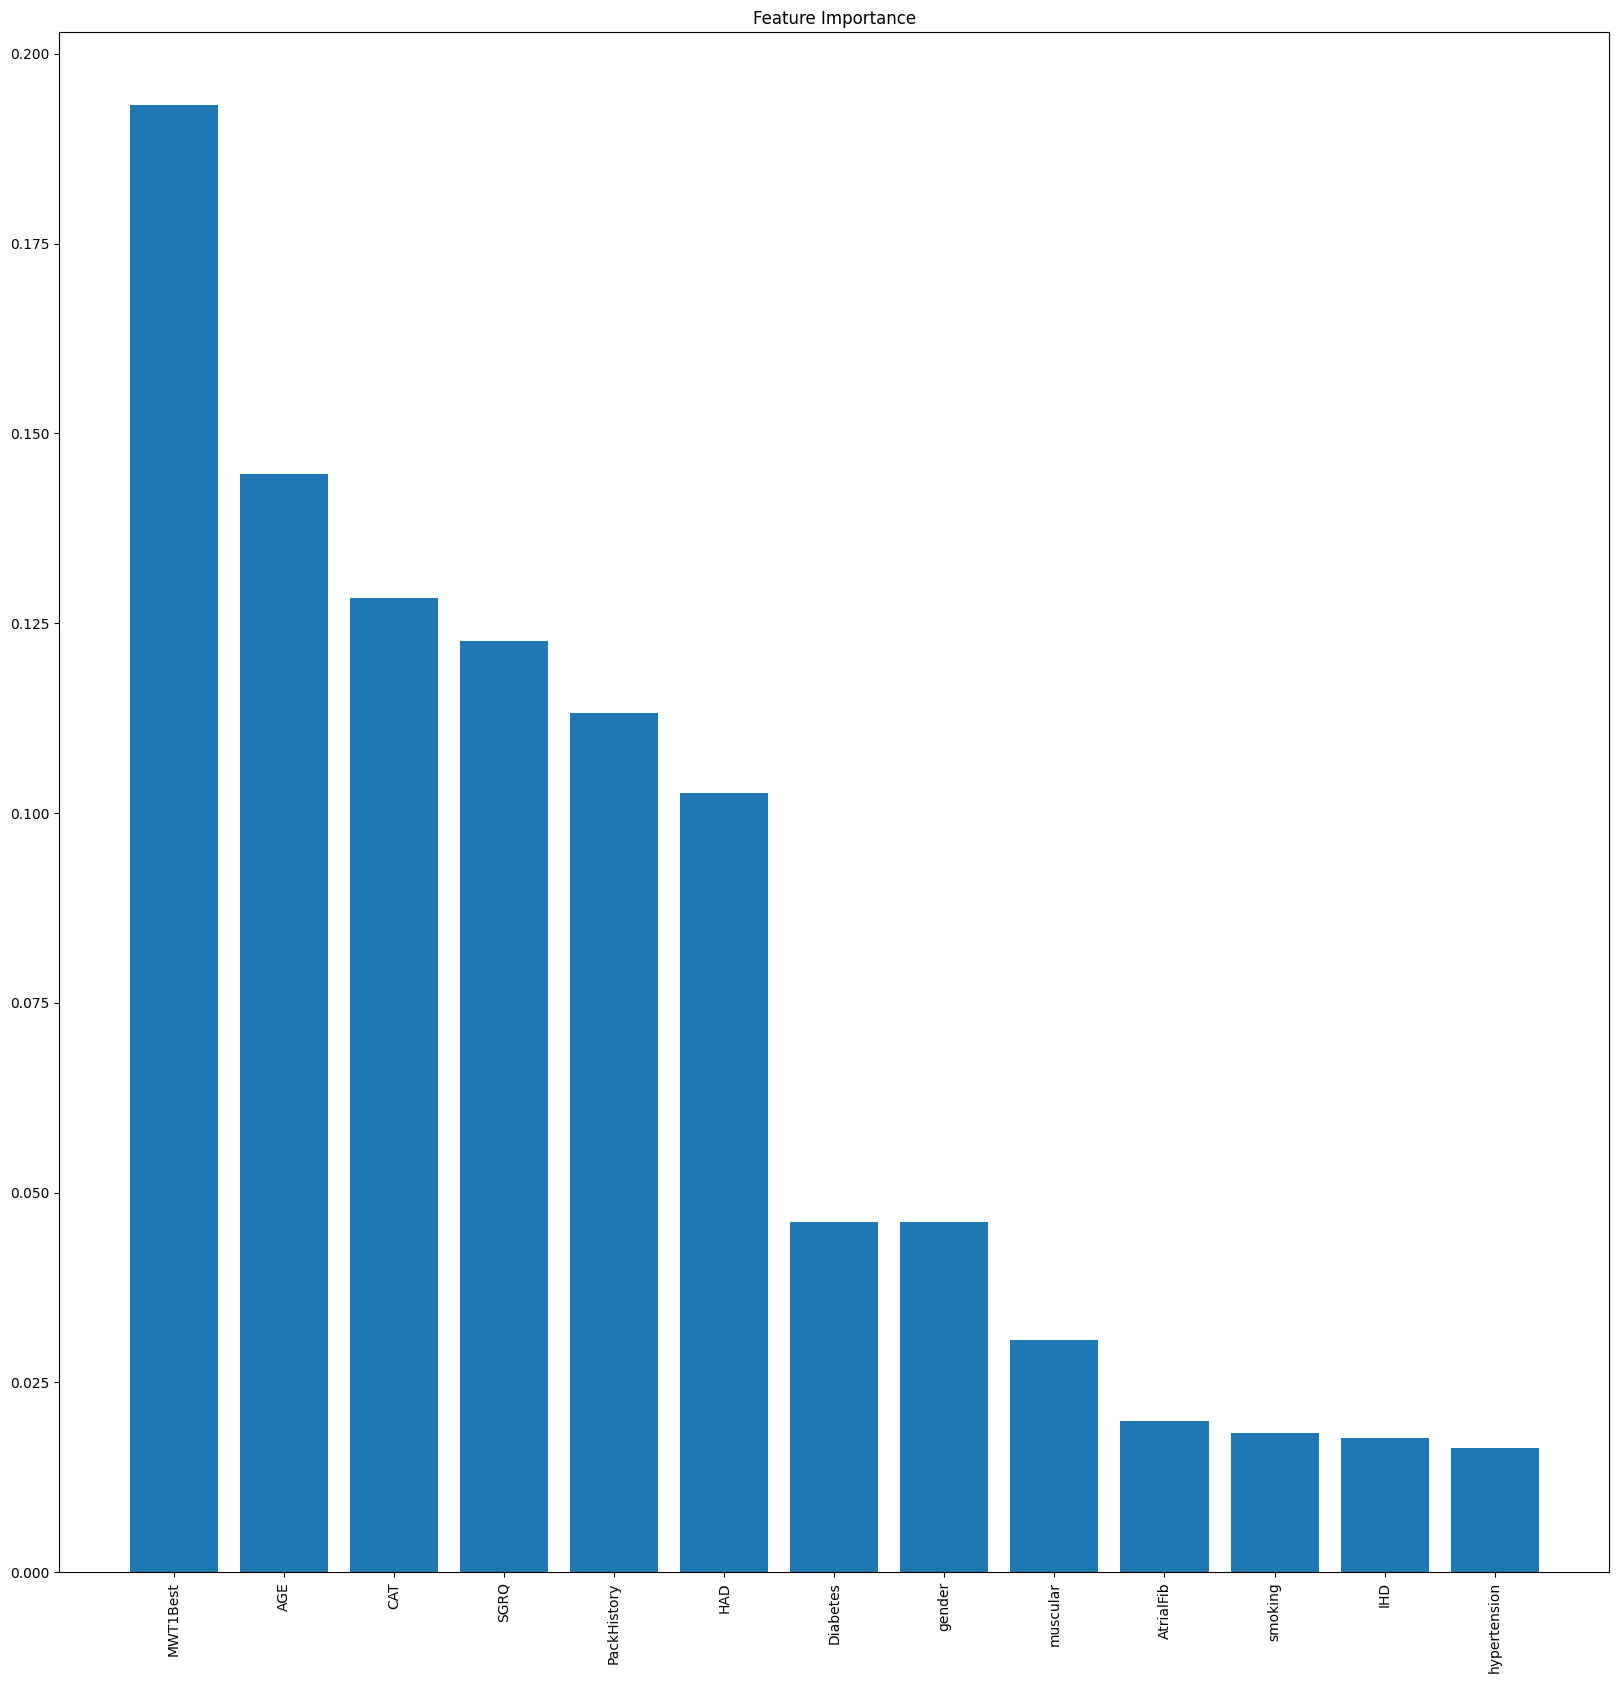

In [54]:
# classification using knn, naives bayes, decision tree, random forest and gradient boosting
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# split the dataset in train and test
X = kaggle.drop(columns=['COPDSEVERITY'])
y = kaggle['COPDSEVERITY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

dt = RandomForestClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# get variable importances
importances = dt.feature_importances_
# sort in descending order
indices = np.argsort(importances)[::-1]
# rearrange feature names so they match the sorted feature importances
names = [kaggle.columns[i] for i in indices]
# create plot
fig = plt.figure(figsize=(20,20))
plt.title("Feature Importance")
# add bars
plt.bar(range(X.shape[1]), importances[indices])
# add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)
# show plot
plt.show()

# Interdataset classification

In [55]:
# harvard

# TODO try without SGRQ for now

target = 'fclinra08'

# relevant variables: AGE, Diabetes, COPDSEVERITY, hypertension, IHD, PackHistory, SGRQ, smoking, MWT1Best 

relevant_vars = ['dem02', 'dem03', 'bclinpt04', 'bclinpt06', 'bclinpt15',  'bclinra14', 'elig09', 'login', target] #bclinpt19 'sgrq_tot_r',(cancer), 'bclinpt36' fast breathing, 'bclinpt08', 'bclinpt09','bclinpt22'

# load harvard dataset
harvard = pd.read_csv('../harvard/data/dropped_variables.csv', sep=";")
harvard = harvard[relevant_vars]

# make female 0 and male = 1
harvard.loc[harvard['dem03'] == 2, 'dem03'] = 0
harvard.loc[harvard['dem03'] == 1, 'dem03'] = 0

# rename columns to common names with exaggerate
harvard = harvard.rename(columns={'dem02':'age', 'dem03': 'gender', 'bclinpt19': 'cancer', 'bclinpt04': 'hypertension', 'bclinpt15': 'diabetes', 'bclinpt07': 'heart_failure', target: 'target', 'bclinra01': 'height', 'bclinra02': 'weight', 'bclinpt34': 'fever',  'bclinpt08':'myocardial_infarct', 'bclinpt09':'stroke', 'bclinpt28':'dyspnoea', 'bclinpt36': 'fast_breathing', 'mmrc': 'mmrc', 'bclinpt22': 'prev_exacerb', 'sgrq_tot_r':'sgrq', 'elig09':'pack_history', 'bclinpt06': 'CAD', 'bclinra14': '6MWT'
 }) 

# get the baseline dataset
unique_logins = harvard['login'].unique()
# baseline dataframe has the same columns as the original dataset
baseline = []
for login in unique_logins:
    # add the first row of the selection to the baseline dataset
    baseline.append(harvard[harvard['login'] == login].iloc[0])
# turn lists into dataframes but with columns from harvard dataset
harvard = pd.DataFrame(baseline, columns=harvard.columns)
# harvard = harvard.drop('login', axis=1)

# swap variable for which yes and no are reversed (yes = 0, no = 1)
harvard['hypertension'] = 1 - harvard['hypertension']

##########
# Missing Values & duplicates
##########


# print missing values per variable and total
print("missing values per variable")
print("total records: "+str(len(harvard)))
print(harvard.isnull().sum())

# drop all records where target is nan
harvard = harvard.dropna(subset=['target'])

numerical_vars = ['age',  'pack_history', '6MWT'] # 'sgrq',
for var in numerical_vars:
    harvard[var] = harvard[var].fillna(harvard[var].median())


# impute gender, cancer, hypertension, diabetes, heart_failure, target with most frequent value
categorical_vars = ['gender', 'hypertension', 'diabetes', 'CAD', 'target', ] # cancer, 'fast_breathing','myocardial_infarct','stroke', 'prev_exacerb'
for var in categorical_vars:
    harvard[var] = harvard[var].fillna(harvard[var].mode()[0])

# print("empty cells remaining in the dataset")
# print(harvard.isnull().sum().sum())

# print("mv imputation")

# plot_hist(harvard)

##########
# Feature engineering
############

harvard['smoking'] = 1

##########
# Normalization
##########

numeric_vars = ['age', 'pack_history', '6MWT'] # 'sgrq',
df_nr = harvard[numeric_vars]
df_rest = harvard.drop(columns=numeric_vars)
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=harvard.index, columns=numeric_vars)
harvard= concat([tmp, df_rest], axis=1)


###########
# Target variable
###########

# if target variable is 1 then set it to 0, otherwise 1
harvard.loc[harvard['target'] == 2, 'target'] = 0

# set all none 0 values to 1
harvard.loc[harvard['target'] == 1, 'target'] = 1
print(harvard['target'].value_counts())

# use smote to rebalance the harvard dataset in place
# print("perform smote")

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(harvard.drop(columns=['target']), harvard['target'])
X_res['target'] = y_res
harvard = X_res

# use undersampling

# # get number of underrespresented class 0
# u = harvard['target'].value_counts().min()
# u_label = harvard['target'].value_counts().idxmin()

# # overrepresented class 1
# o = harvard['target'].value_counts().max()
# o_label = harvard['target'].value_counts().idxmax()

# # add all underrepresented samples to a new dataframe
# underrepresented = harvard[harvard['target'] == u_label]
# # sample u number of overrepresented samples from the dataset
# overrepresented = harvard[harvard['target'] == o_label].sample(n=u, random_state=42)
# # concatenate underrepresented and overrepresented
# harvard = pd.concat([underrepresented, overrepresented])
# # plot_hist(harvard)
# print(harvard['target'].value_counts())

# sort the columns
harvard = harvard.reindex(sorted(harvard.columns), axis=1)


missing values per variable
total records: 188
age               0
gender            0
hypertension     10
CAD              11
diabetes         11
6MWT            101
pack_history      8
login             0
target           38
dtype: int64
0.00    126
1.00     24
Name: target, dtype: int64


In [57]:
# import random forest
from sklearn.ensemble import RandomForestClassifier
# import lazypredict
from lazypredict.Supervised import LazyClassifier

# relevant variables: AGE, Diabetes, COPDSEVERITY, hypertension, IHD, PackHistory, SGRQ, smoking, MWT1Best (without spirometry for now)


kaggle_cv = kaggle[['AGE', 'gender', 'hypertension', 'Diabetes', 'IHD', 'PackHistory',  'smoking', 'MWT1Best', 'COPDSEVERITY']] # 'SGRQ',

# 6MWT, pack history, age
# kaggle_cv = kaggle_cv[['AGE', 'PackHistory', 'MWT1Best', 'COPDSEVERITY']]

# if COPDSEVERITY is 1,2,3 set it to 0 otherwise 1
kaggle_cv.loc[kaggle_cv['COPDSEVERITY'] == 1, 'COPDSEVERITY'] = 0
kaggle_cv.loc[kaggle_cv['COPDSEVERITY'] == 2, 'COPDSEVERITY'] = 1
kaggle_cv.loc[kaggle_cv['COPDSEVERITY'] == 3, 'COPDSEVERITY'] = 1
kaggle_cv.loc[kaggle_cv['COPDSEVERITY'] == 4, 'COPDSEVERITY'] = 1
kaggle_cv = kaggle_cv.rename(columns={'AGE':'age', 'Diabetes':'diabetes', 'IHD':'CAD', 'PackHistory':'pack_history', 'MWT1Best':'6MWT', 'COPDSEVERITY': 'target'})
# sort the columns
kaggle_cv = kaggle_cv.reindex(sorted(kaggle_cv.columns), axis=1)

harvard_cv = harvard.drop(columns=['login'])
# harvard_cv = harvard_cv[['age', 'pack_history', '6MWT', 'target']]

# sort the columns
harvard_cv = harvard_cv.reindex(sorted(harvard_cv.columns), axis=1)
print(harvard_cv.columns)

train = kaggle_cv.drop(columns=['target'])
print(train.columns)
target = kaggle_cv['target']

# # train random forest on kaggle predict on harvard
# rf = RandomForestClassifier()
# rf.fit(train, target)

# # predict on harvard
# rf.predict(harvard_cv.drop(columns=['target']))
# # get accuracy
# print(rf.score(harvard_cv.drop(columns=['target']), harvard_cv['target']))
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(train, harvard_cv.drop(columns=['target']), target, harvard_cv['target'])
models


Index(['6MWT', 'CAD', 'age', 'diabetes', 'gender', 'hypertension',
       'pack_history', 'smoking', 'target'],
      dtype='object')
Index(['6MWT', 'CAD', 'age', 'diabetes', 'gender', 'hypertension',
       'pack_history', 'smoking'],
      dtype='object')


100%|██████████| 29/29 [00:00<00:00, 53.94it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BaggingClassifier,0.54,0.54,0.54,0.45,0.02
DecisionTreeClassifier,0.53,0.53,0.53,0.44,0.01
ExtraTreeClassifier,0.53,0.53,0.53,0.44,0.01
QuadraticDiscriminantAnalysis,0.53,0.53,0.53,0.44,0.01
LGBMClassifier,0.52,0.52,0.52,0.41,0.02
PassiveAggressiveClassifier,0.52,0.52,0.52,0.50,0.01
CalibratedClassifierCV,0.52,0.52,0.52,0.40,0.03
ExtraTreesClassifier,0.52,0.52,0.52,0.38,0.08
XGBClassifier,0.52,0.52,0.52,0.41,0.03
